In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import datetime
import json
from data_util import prepare_data
from model_util import create_model_attention

plt.interactive(True)
pd.options.plotting.backend='plotly'

current_time = datetime.datetime.now()
time = current_time.strftime("%Y-%m-%d %H:%M:%S%z") #"%Y%m%d_%H%M" impianto

# Options

- hour-ahead!

In [33]:
# gpus = tf.config.list_physical_devices('GPU')
# print(gpus)

path = "./Output/Trial_" + time

sito = 'JPL'         #'impianto4'

file_opt = {
    'file': sito,
    'directory_file': "./dati/",
    'dt_format': "%d/%m/%Y %H:%M",
    'to_timezone': 'America/Los_Angeles'}   #Europe/Rome

manage_file = {
    'filtra_by_date': True,  # per restituire una porzione di df - insieme a inizio_filtro fine_filtro
    'aggregate_w_we': 'by_day',  # 'grouped' # by_day --> se grouped 0,1 su colonna week_day
    'only_week_weekend': False,  # 'week',  # 'week',  # week weekend False
    'single_day': False,  # 'monday'# False # 'tuesday'
    'remove_nan_ID': False,  # remove session when user ID is not given
    'togli_durata_inferiore': False,  # se durata sessione inferiore a {minuti} --> rimuovi
}
# scaled = values
# specify the number of lag hours
data_opt = {
    #'reload_data': False,
    'n_back': 96*3,  # 4*24*7
    'n_timesteps': 4,  # 4*4
    'lag': 0,
    'dataset_split': 'data', # 'percentage', data
    'tr_per': 0.90,
    #'training_test_split_data': '30/05/2023 00:15',
    'out_col': ['power'],      #Potenza
    'features': []#['year', 'month', 'day', 'hour', 'minute'],
}

data_opt['columns'] = data_opt['features'] + data_opt['out_col']
data_opt['n_features'] = len(data_opt['columns'])

model_opt = {'LSTM_num_hidden_units': [24],
             #'LSTM_layers': 1,
             'input_dim': (data_opt['n_back'], data_opt['n_features']),
             'dense_out': data_opt['n_timesteps'],
             'neurons_activation': 'relu',
             'metrics': 'mse',
             'optimizer': 'adam',
             'patience': 5,
             'epochs': 30,
             'validation_split': 0.2,
             'model_path': './Output/',
             'Dropout_rate': 0.2,
             }

definizione parametri


# Data

## Import

In [34]:
dataset = pd.read_csv('dati/train_JPL_2_pressure_washed.csv',sep=';')
dataset['times_utc'] = pd.to_datetime(dataset['times_utc'], format=file_opt['dt_format'])
dataset.set_index('times_utc', inplace=True)
#data_opt['training_test_split_data'] = pd.to_datetime(data_opt['training_test_split_data'], format=file_opt['dt_format'])

dataset = dataset.resample('15min').mean()


## Clean (optional)

Helpful while cleaning

In [35]:
#from utils_mjw import *
#dataset['weekday'] = dataset.index.weekday*10
#year_month = '2023-10'
#plot_weekly(dataset.loc[year_month].power,alpha=0.3)
#dataset[['weekday','power']].loc[year_month].plot()

In [36]:
dataset = pd.read_csv('dati/train_JPL_2.csv',sep=';')

dataset['times_utc'] = pd.to_datetime(dataset['times_utc'], format=file_opt['dt_format'])
dataset.set_index('times_utc', inplace=True)
dataset = dataset.resample('15min').mean()

dataset.loc['2021-11-22':'2021-11-26']  = dataset.loc['2021-11-15':'2021-11-19'].values
dataset.loc['2021-11-22']               = dataset.loc['2021-11-15'].values
dataset.loc['2021-12-17':'2021-12-21']  = dataset.loc['2021-12-10':'2021-12-14'].values
dataset.loc['2021-12-24':'2021-12-28']  = dataset.loc['2021-12-17':'2021-12-21'].values

dataset.loc['2022-1-3':'2022-1-7']      = dataset.loc['2022-1-10':'2022-1-14'].values
dataset.loc['2022-1-24']                = dataset.loc['2022-1-17'].values
dataset.loc['2022-2-21']                = dataset.loc['2022-2-14'].values
dataset.loc['2022-3-4']                 = dataset.loc['2022-3-3'].values
dataset.loc['2022-5-10':'2022-5-12']    = dataset.loc['2022-5-3':'2022-5-5'].values
dataset.loc['2022-5-23':'2022-5-24']    = dataset.loc['2022-5-16':'2022-5-17'].values
dataset.loc['2022-7-6':'2022-7-8']      = dataset.loc['2022-6-29':'2022-7-1'].values
dataset.loc['2022-9-5']                 = dataset.loc['2022-8-29'].values

dataset.loc['2023-6-22':'2023-6-23']    = dataset.loc['2023-6-15':'2023-6-16'].values
dataset.loc['2023-7-18':'2023-7-21']    = dataset.loc['2023-7-11':'2023-7-14'].values
dataset.loc['2023-7-25':'2023-7-27']    = dataset.loc['2023-7-4':'2023-7-6'].values
dataset.loc['2023-8-14']                = dataset.loc['2023-8-7'].values
dataset.loc['2023-9-11']                = dataset.loc['2023-9-4'].values
dataset.loc['2023-10-5']                = dataset.loc['2023-9-28'].values
dataset.loc['2023-10-10':'2023-10-12']  = dataset.loc['2023-10-3':'2023-10-5'].values

## Shape

In [37]:
dataset['year'] = dataset.index.year
dataset['month'] = dataset.index.month
dataset['day'] = dataset.index.dayofweek
dataset['hour'] = dataset.index.hour
dataset['minute'] = dataset.index.minute

dataset = dataset[data_opt['columns']]

# print('data loaded')
train_X, train_y, test_X, test_y, scaler_X, scaler_y  = prepare_data(dataset, data_opt)
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1)) #solo ENC-DEC
# a = np.load('dati_veicoli/train_X.npy')

# Model

## Build

In [38]:
# smltn_chr = 'forecast'

with open(model_opt['model_path'] + 'Param.txt', 'w') as convert_file:
    convert_file.write(json.dumps(data_opt))
    convert_file.write(json.dumps(model_opt))

## Train

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 288, 1)]             0         []                            
                                                                                                  
 lstm_2 (LSTM)               [(None, 288, 24),            2496      ['input_3[0][0]']             
                              (None, 24),                                                         
                              (None, 24)]                                                         
                                                                                                  
 attention_1 (attention)     (None, 24)                   312       ['lstm_2[0][0]']              
                                                                                            

C:\Users\Admin\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



1072/1072 [==============================] - 42s 40ms/step - loss: 0.0017 - val_loss: 0.0024
Epoch 3/30
1072/1072 [==============================] - 43s 40ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 4/30
1072/1072 [==============================] - 43s 40ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 5/30
1072/1072 [==============================] - 43s 40ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 6/30
1072/1072 [==============================] - 43s 40ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 7/30
1072/1072 [==============================] - 43s 40ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 8/30
1072/1072 [==============================] - 42s 40ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/30
1072/1072 [==============================] - 42s 39ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 10/30
1072/1072 [==============================] - 42s 39ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 11/30
1072/1072 [==============================] - 42s 39ms/step - l

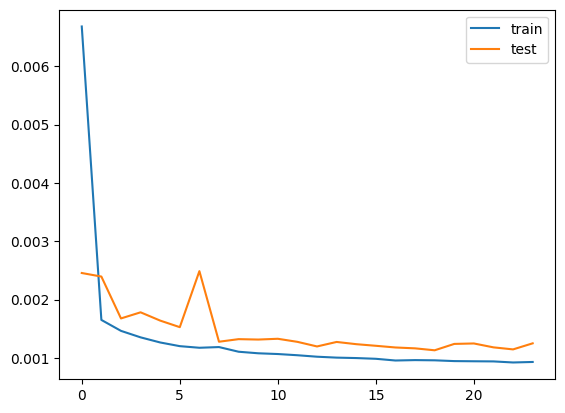

In [39]:
model_create_load_tune= 'create' # tune , load
if model_create_load_tune == 'create':
    model, history = create_model_attention(model_opt, train_X, train_y)
    model.save(model_opt['model_path'] + 'my_model/microgrid_model.h5')

    # plot history
    plt.figure()
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.savefig(model_opt['model_path'] + 'history.png')


## Predict

In [40]:
# make a prediction
yhat_np = model.predict(test_X)
yhat_np = yhat_np.reshape((yhat_np.shape[0], yhat_np.shape[1]))

# invert scaling for forecast
inv_yhat = scaler_y.inverse_transform(yhat_np)

y_hat = pd.DataFrame(data=inv_yhat, columns=test_y.columns, index=test_y.index)

149/149 [==============================] - 2s 12ms/step


In [42]:
# save
y_hat.to_csv(f"{model_opt['model_path']}forecast.csv")
test_y.to_csv(f"{model_opt['model_path']}measures.csv")

# Plot

Hour-ahead

In [50]:
viz_horizon_h = 1
horizon_h = int(data_opt['n_timesteps']/4)

idx = pd.date_range(y_hat.index[0],periods=int(168/viz_horizon_h),freq=f'{viz_horizon_h}h')

out1_tplus = [f'out1(t+{t})' for t in range(4*viz_horizon_h)]

y_hat_flat = y_hat[out1_tplus].loc[idx].values.flatten()

test_y_flat = test_y[out1_tplus].loc[idx].values.flatten()

mae = (((y_hat_flat - test_y_flat)**2)**(0.5)).mean()

pd.DataFrame({'y_hat':y_hat_flat,'test_y':test_y_flat},
            index=pd.date_range(idx[0],periods=len(y_hat_flat),freq='15min'))\
                .plot(title=f'LSTM horizon = {horizon_h}h (showing first {viz_horizon_h}h)<br>'+\
                            f'MAE = {mae:.2f} kW',
                      height=600, width=1000)